In [ ]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/data exercises/train.csv")
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
# Account for imbalance in data set

from sklearn.model_selection import train_test_split
df_train_0, df_test_0 = train_test_split(df[df['is_duplicate'] == 0], train_size=0.8,random_state=0)
df_train_1, df_test_1 = train_test_split(df[df['is_duplicate'] == 1], train_size=0.8,random_state=0)

df_train = pd.concat([df_train_0, df_train_1]).sample(frac=1)
df_test = pd.concat([df_test_0, df_test_1]).sample(frac=1)
y_train = df_train['is_duplicate']
y_test = df_test['is_duplicate']
print(y_test.shape)

# Make sure no rows got dropped
print(len(df_train)+len(df_test)==len(df))
df_test.head()

(80859,)
True


,id,qid1,qid2,question1,question2,is_duplicate
117829,117829,191655,191656,"What are the differences between mRNA, tRNA, a...",What are the differences between mRNA and tRNA?,0
107380,107380,176687,176688,How do make my routine for studying at least 1...,Mechanical enginer at jpl?,0
253316,253316,252126,362294,Do IAS officers get national holidays?,Do IAS officers get holidays?,1
8245,8245,16081,16082,How many atoms are there in the Universe?,How many particles are there in the universe?,0
395893,395893,528917,528918,How do you tell your parents you got an “F” in...,How do I tell my parents that I got an F?,1


In [ ]:
df_test.sort_values('is_duplicate', ascending=False)

,id,qid1,qid2,question1,question2,is_duplicate
204823,204823,103004,6699,How do I stop my American Staffy/Kelpie mix fr...,How do I stop my Shepherd-Husky mix puppy from...,1
147006,147006,67070,61456,Why has the Tata sons board voted to remove Cy...,Why has the Tata Sons Board voted to remove Cy...,1
63104,63104,97812,109872,"I'm away from home, How do I celebrate Diwali ...",How can one celebrate Diwali (Festival of Ligh...,1
378662,378662,42558,202834,What the benefits of smoking weed?,What are the benefits of smoking weed?,1
137450,137450,37698,29331,Why don't people just Google their questions?,Why don't Quora people just look up the answer...,1
...,...,...,...,...,...,...
374192,374192,219962,505066,How do I calculate engineering aggregate perce...,"I'm a VTU pass-out, applying for ias exam. Wha...",0
190406,190406,36294,289471,What are the best books on Islamic philosophy?,What are some good books on Islamic economics?,0
317143,317143,442296,442297,How long would it take for a colony on Mars to...,How cool would it be if we could transfer our ...,0
312408,312408,436852,156399,Is there a smart village in India?,How can we develop a village as a smart villag...,0


# Forest Models

In [ ]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Forest models
    # Data prep using .itertuples()
# %%time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
def process_doc(doc):

    # remove special characters
    doc = ''.join([char for char in str(doc) if not char in string.punctuation]) ###

    # Split text into single words (also gets rid of extra white spaces)
    words = word_tokenize(doc)

    # Convert to lower case
    words = [word.lower() for word in words]

    # Stem
    # porter = PorterStemmer()
    # words = [porter.stem(word) for word in words]
    wnl = WordNetLemmatizer()
    words = [wnl.lemmatize(word) for word in words]

    return words

# feature engineering
def process_pairs(df):
    """
    Perform feature engineering on pairs of questions for forest models.
    """

    length_diff = []
    n_common_words = []
    df2 = pd.DataFrame()
    for index, q1, q2 in df[['question1', 'question2']].itertuples():
        # Preprocess
        tokens1 = process_doc(q1)
        tokens2 = process_doc(q2)
        # print(tokens1)
        # print(tokens2)
        # print()

        # Get number of words for q1 and a2 and the ratio of these values
        df2.loc[index,'Q1 length'] = int(len(tokens1))
        df2.loc[index,'Q2 length'] = len(tokens2)
        df2.loc[index,'length ratio'] = min([len(tokens1), len(tokens2)]) / max([len(tokens1), len(tokens2)])

        # Number of common words between q1 and q2
        common_words = set(tokens1) & set(tokens2)
        df2.loc[index,'N common words'] = len(common_words)

        # Common words between q1 and q2 as a percentage of longest question in the pair
        df2.loc[index,'common words percentage'] = len(common_words) / max([len(tokens1), len(tokens2)])
        try:
            df2.loc[index,'same last word'] = int(tokens1[-1] == tokens2[-1])
        except:
            df2.loc[index,'same last word'] = 0

        # Same frequency of the word 'not'
        df2.loc[index,'not_count1'] = sum(word=='not' for word in tokens1)
    
        # # Remove stop words aside from the 5 why's + how
        stop_words = set(stopwords.words('english')) - set(['who', 'what', 'where', 'when', 'how', 'why'])
        words1 = [w for w in tokens1 if not w in stop_words]
        words2 = [w for w in tokens2 if not w in stop_words]

        # Number of common words between q1 and q2 with stop words removed
        common_words_nonstop = set(words1) & set(words2)
        df2.loc[index,'N common non-stop words'] = len(common_words_nonstop)
        df2.loc[index,'common non-stop words percentage'] = len(common_words_nonstop) / max(
            [len(words1), len(words2)])
        
        # print(words2,'\n')
        
    # length difference
    df2['Q1 Q1 length difference'] = abs(df2['Q1 length'] - df2['Q2 length'])

    return df2
        

# X_train = process_pairs(df_train)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
y_test

16290     0
293587    0
129570    0
282137    0
377862    0
         ..
179307    0
291522    1
185729    1
307605    0
18270     0
Name: is_duplicate, Length: 4043, dtype: int64

In [ ]:
print(type(X_train))
import pickle
with open('drive/MyDrive/data exercises/X_train.sav', 'wb') as fh:
   pickle.dump(X_train, fh)

In [ ]:
# Load saved X_train dataframe
import pickle
pickle_off = open('drive/MyDrive/data exercises/X_train.sav', 'rb')
X_train = pickle.load(pickle_off)
X_train

,Q1 length,Q2 length,length ratio,N common words,common words percentage,same last word,not_count1,N common non-stop words,common non-stop words percentage,Q1 Q1 length difference
248660,5.0,8.0,0.625000,4.0,0.500000,0.0,0.0,4.0,0.666667,3.0
367938,11.0,10.0,0.909091,6.0,0.545455,0.0,0.0,5.0,0.625000,1.0
131579,8.0,6.0,0.750000,6.0,0.750000,0.0,0.0,3.0,0.750000,2.0
94669,8.0,10.0,0.800000,0.0,0.000000,0.0,0.0,0.0,0.000000,2.0
273892,8.0,6.0,0.750000,5.0,0.625000,0.0,0.0,3.0,0.750000,2.0
...,...,...,...,...,...,...,...,...,...,...
148564,11.0,12.0,0.916667,8.0,0.666667,1.0,0.0,4.0,0.666667,1.0
226406,6.0,10.0,0.600000,2.0,0.200000,0.0,0.0,2.0,0.285714,4.0
382161,12.0,13.0,0.923077,8.0,0.615385,0.0,0.0,4.0,0.500000,1.0
307244,11.0,12.0,0.916667,11.0,0.916667,1.0,0.0,6.0,0.857143,1.0


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
class ClfSwitcher(BaseEstimator):
# Create a class named ClfSwitcher which inherits the base class called BaseEstimator from sklearn.
    def __init__(self, estimator = LogisticRegression()):
            self.estimator = estimator # receives an estimator (model) as an input
            
    def fit(self, X, y=None, **kwargs):
            self.estimator.fit(X, y)
            return self
            
    def predict(self, X, y=None):
            return self.estimator.predict(X)
            
    def predict_proba(self, X):
            return self.estimator.predict_proba(X)
            
    def score(self, X, y):
            return self.estimator.score(X, y)


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
forest_pipe = Pipeline([
    # ('process_pairs', FunctionTransformer(process_pairs)),
    ('model', ClfSwitcher())
])
# forest_pipe.fit_transform(df.head()) # This line works before the modeling step
grid_params = [
    # {
    #     'model__estimator': [LogisticRegression(random_state=0)],
    #     'model__estimator__class_weight': [None, 'balanced']
    #     },
    # {
    #     'model__estimator': [SVC(random_state=0)],
    #     'model__estimator__class_weight': [None, 'balanced']
    #     },
    {
        'model__estimator': [xgb.XGBClassifier(random_state=0)],
        'model__estimator__n_estimators': [100, 50]
        },
    {
        'model__estimator': [RandomForestClassifier(random_state=0)],
        'model__estimator__n_estimators': [50, 100, 150]
        },
    ]
gs = GridSearchCV(forest_pipe, grid_params, scoring='accuracy')
y_pred_train = gs.fit(X_train, y_train) # 2022-11-17 20:36 accidentally named the fit grid search model as y_pred_train even though no predictions made yet
# print(gs.best_estimator_)
print(gs.best_params_)

{'model__estimator': XGBClassifier(n_estimators=50), 'model__estimator__n_estimators': 50}


In [ ]:
# Save gs result


from datetime import datetime
def savepickle(model,filename,path=None,append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename)

path=r'drive/MyDrive/data exercises'
filename = 'grid_search_result.sav' 
savepickle(y_pred_train,filename,path=path, append_version=True)

File saved:  drive/MyDrive/data exercises/grid_search_result.sav2022-11-18_0435


## Function: Evaluate Classifier 

In [ ]:
# Updated 2022-11-18 10:45 so roc score prints even if classification dtypes are float.
# Updated so that y_pred_train is passed instead of X_train to avoid having to refit the model.
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_classifier(classifier, X_test, y_test, y_train, y_pred_train, pos_label=1,model_name='classifier', confusion_matrix=True):
    """
    Print evaluation metrics of the classifier. Classifier should be fit prior to calling this function.
        * recall
        * precision
        * F1
        * AUC score (only if class labels are integers)
    Plot:
        * confusion matrix
        * ROC (only if class labels are integers)
    Parameters:
    - pos_label (str or int): Class label for positive class. Default is 1.
    - model_name (string, optional): Name of model printing purposes.
    - confusion_matrix (bool): If True (default), print the confusion matrix. 

    Returns 2 dictionaries:
    - evaluation metrics for test data
    - evaluation metrics train data set
    """
    
    best_model = classifier
    print(best_model.best_estimator_)

    y_pred = best_model.predict(X_test)

    # y_pred_train = best_model.predict(X_train)

    # Metrics for test data
    metrics = dict()
    if len(set(y_test)) == 2:
        recall = recall_score(y_test, y_pred, pos_label=pos_label)
        precision = precision_score(y_test, y_pred, pos_label=pos_label)
        f1score = f1_score(y_test, y_pred, pos_label=pos_label)
        metrics['recall'] = recall
        metrics['precision'] = precision
        metrics['f1'] = f1score

    accuracy = accuracy_score(y_test, y_pred)
    metrics['accuracy'] = accuracy

    # Metrics for training data
    metrics_train = dict()
    if len(set(y_test)) == 2:
        recall_train = recall_score(y_train, y_pred_train, pos_label=pos_label)
        precision_train = precision_score(y_train, y_pred_train, pos_label=pos_label)
        f1score_train = f1_score(y_train, y_pred_train, pos_label=pos_label)
        metrics_train['recall'] = recall_train
        metrics_train['precision'] = precision_train
        metrics_train['f1'] = f1score_train
    accuracy_train = accuracy_score(y_train, y_pred_train)
    metrics_train['accuracy'] = accuracy_train

    print(f'\n{model_name} evaluation metrics: \n\tTest data\tTraining data\t\tDifference')
    print(f'Accuracy: \t{100*accuracy:.2f}%\t\t{100*accuracy_train:.2f}%\t\t{100*(accuracy-accuracy_train):.2f}%')
    if len(set(y_test)) == 2:
        print(f'Recall: \t{100*recall:.2f}%\t\t{100*recall_train:.2f}%\t\t{100*(recall-recall_train):.2f}%')
        print(f'Precision: \t{100*precision:.2f}%\t\t{100*precision_train:.2f}%\t\t{100*(precision-precision_train):.2f}%')
        print(f'F1: \t\t{100*f1score:.2f}%\t\t{100*f1score_train:.2f}%\t\t{100*(f1score-f1score_train):.2f}%')
        if (type(y_test) == 'int') | (type(y_test) == 'float'):
            auc = roc_auc_score(y_test, y_pred)
            auc_train = roc_auc_score(y_train, y_pred_train)
            RocCurveDisplay.from_predictions(y_test, y_pred)
            metrics['auc'] = auc
            print(f'AUC: \t\t{100*auc:.2f}%\t\t{100*auc_train:.2f}%\t\t{100*(auc-auc_train):.2f}%')
    if confusion_matrix==True:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    return metrics, metrics_train, y_pred

In [ ]:
y_pred_train

GridSearchCV(estimator=Pipeline(steps=[('model', ClfSwitcher())]),
             param_grid=[{'model__estimator': [XGBClassifier(n_estimators=50)],
                          'model__estimator__n_estimators': [100, 50]},
                         {'model__estimator': [RandomForestClassifier(random_state=0)],
                          'model__estimator__n_estimators': [50, 100, 150]}],
             scoring='accuracy')

In [ ]:
fit_gs_model = y_pred_train
fit_gs_model.best_estimator_

Pipeline(steps=[('model',
                 ClfSwitcher(estimator=XGBClassifier(n_estimators=50)))])

In [ ]:
# Transform X_test (~4000 samples in this run)
X_test = process_pairs(df_test)

path=r'drive/MyDrive/data exercises'
filename = 'X_test.sav' 
savepickle(y_pred_train,filename,path=path, append_version=True)

File saved:  drive/MyDrive/data exercises/X_test.sav2022-11-18_0440


In [ ]:
# Make predictions for X_train
y_pred_train = gs.predict(X_train)
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
gs

GridSearchCV(estimator=Pipeline(steps=[('model', ClfSwitcher())]),
             param_grid=[{'model__estimator': [XGBClassifier(n_estimators=50)],
                          'model__estimator__n_estimators': [100, 50]},
                         {'model__estimator': [RandomForestClassifier(random_state=0)],
                          'model__estimator__n_estimators': [50, 100, 150]}],
             scoring='accuracy')

In [ ]:
# Make predictions for X_test
y_pred_test = gs.predict(X_test)
y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
sum(y_pred_test)

0

In [ ]:
sum(y_test)

29853

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



XGBClassifier evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	63.94%		63.08%		0.86%
Recall: 	0.00%		0.00%		-0.00%
Precision: 	0.00%		75.00%		-75.00%
F1: 		0.00%		0.01%		-0.01%


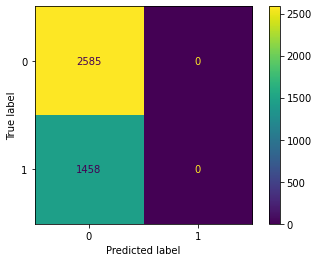

In [ ]:
# Evaluate
metrics, metrics_train, y_pred = evaluate_classifier(gs, X_test, y_test, y_train, y_pred_train, pos_label=1,model_name='XGBClassifier')

In [ ]:
metrics

{'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.6393767004699481}

# Iteration 2

In [ ]:
forest_pipe = Pipeline([
    # ('process_pairs', FunctionTransformer(process_pairs)),
    ('model', ClfSwitcher())
])

grid_params = [
    {
        'model__estimator': [xgb.XGBClassifier(random_state=0)],
        # 'model__estimator__n_estimators': [100, 50]
        },
    {
        'model__estimator': [RandomForestClassifier(random_state=0)],
        'model__estimator__n_estimators': [50, 100, 150],
        'model__estimator__min_samples_leaf' : [3, 4, 5, 6]
        },
    ]
gs2 = GridSearchCV(forest_pipe, grid_params, scoring='accuracy')
gs2.fit(X_train, y_train)
print(gs2.best_params_)
gs2

{'model__estimator': XGBClassifier()}


GridSearchCV(estimator=Pipeline(steps=[('model', ClfSwitcher())]),
             param_grid=[{'model__estimator': [XGBClassifier()]},
                         {'model__estimator': [RandomForestClassifier(random_state=0)],
                          'model__estimator__min_samples_leaf': [3, 4, 5, 6],
                          'model__estimator__n_estimators': [50, 100, 150]}],
             scoring='accuracy')

In [ ]:
path=r'drive/MyDrive/data exercises'
filename = 'grid_search2_result.sav' 
savepickle(gs2,filename,path=path, append_version=True)

File saved:  drive/MyDrive/data exercises/grid_search2_result.sav2022-11-18_0544


In [ ]:
# y_pred_train
y_pred_train2 = gs2.predict(X_train)
sum(y_pred_train2)

85

In [ ]:
# Bigger X_test ; 
X_test = process_pairs(df_test)
print(X_test.shape) # 2022-11-18 7:53 Saved incorrectly

In [ ]:

path=r'drive/MyDrive/data exercises'
filename = 'X_test.sav' 
savepickle(y_pred_train,filename,path=path, append_version=True) # 2022-11-18 7:53 Saved incorrectly

File saved:  drive/MyDrive/data exercises/X_test.sav2022-11-18_0616


In [ ]:
print(y_test.shape)

(80859,)



XGBClassifier evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	63.06%		63.07%		-0.02%
Recall: 	0.00%		0.03%		-0.03%
Precision: 	0.00%		35.29%		-35.29%
F1: 		0.00%		0.05%		-0.05%


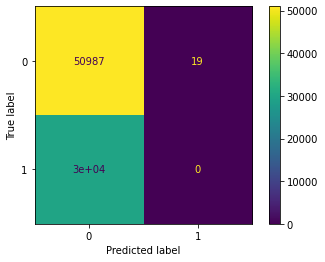

In [ ]:
metrics2, metrics_train2, y_pred2 = evaluate_classifier(gs2, X_test, y_test, y_train, y_pred_train2, pos_label=1,model_name='XGBClassifier')

# Iteration 3: 
* Different scoring metrics
* Account for class imbalance

In [ ]:
forest_pipe = Pipeline([
    ('model', ClfSwitcher())
  ])
scoring = {"AUC": "roc_auc", "recall": 'recall'}
grid_params = [
    {
        'model__estimator': [RandomForestClassifier(random_state=0)],
        'model__estimator__n_estimators': [50, 100, 150],
        # 'model__estimator__min_samples_leaf' : [3, 4, 5, 6],
        'model__estimator__class_weight' : [None, 'balanced']
        },
    ]

gs3 = GridSearchCV(forest_pipe, grid_params, scoring='roc_auc')
gs3.fit(X_train, y_train)
print(gs3.best_params_)

path=r'drive/MyDrive/data exercises'
filename = 'grid_search3_result.sav' 
savepickle(gs3,filename,path=path, append_version=True)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 109, in __get__
    if not self.check(obj):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 45, in check
    getattr(self._final_estimator, attr)
AttributeError: 'ClfSwitcher' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local

{'model__estimator': RandomForestClassifier(n_estimators=50, random_state=0), 'model__estimator__class_weight': None, 'model__estimator__n_estimators': 50}
File saved:  drive/MyDrive/data exercises/grid_search3_result.sav2022-11-18_0604



RandomForestClassifier evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	57.47%		58.70%		-1.22%
Recall: 	13.69%		16.79%		-3.10%
Precision: 	32.16%		36.94%		-4.78%
F1: 		19.20%		23.08%		-3.88%


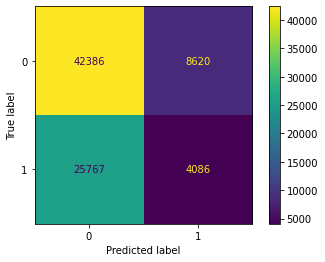

In [ ]:
y_pred_train3 = gs3.predict(X_train)
metrics3, metrics_train3, y_pred3 = evaluate_classifier(gs3, X_test, y_test, y_train, y_pred_train3, pos_label=1,model_name='RandomForestClassifier')

# Iteration 4: 'recall' as scoring metric, set min_samples_leaf

{'model__estimator': RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=150, random_state=0), 'model__estimator__class_weight': 'balanced', 'model__estimator__min_samples_leaf': 5, 'model__estimator__n_estimators': 150}
File saved:  drive/MyDrive/data exercises/grid_search4_result.sav2022-11-18_0750
Pipeline(steps=[('model',
                 ClfSwitcher(estimator=RandomForestClassifier(class_weight='balanced',
                                                              min_samples_leaf=5,
                                                              n_estimators=150,
                                                              random_state=0)))])

RandomForestClassifier evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	52.42%		64.54%		-12.12%
Recall: 	45.32%		62.73%		-17.41%
Precision: 	37.92%		51.63%		-13.71%
F1: 		41.29%		56.64%		-15.35%
File saved:  drive/MyDrive/data exercises/y_pred4.sav2022-11-18_0750


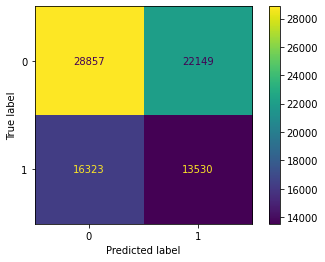

In [ ]:
forest_pipe = Pipeline([
    ('model', ClfSwitcher())
  ])
scoring = {"AUC": "roc_auc", "recall": 'recall'}
grid_params = [
    {
        'model__estimator': [RandomForestClassifier(random_state=0)],
        'model__estimator__n_estimators': [100, 150, 200],
        'model__estimator__min_samples_leaf' : [3, 4, 5],
        'model__estimator__class_weight' : [None, 'balanced']
        },
    ]

gs4 = GridSearchCV(forest_pipe, grid_params, scoring='recall')
gs4.fit(X_train, y_train)
print(gs4.best_params_)

path=r'drive/MyDrive/data exercises'
filename = 'grid_search4_result.sav' 
savepickle(gs4,filename,path=path, append_version=True)

y_pred_train4 = gs4.predict(X_train)
metrics4, metrics_train4, y_pred4 = evaluate_classifier(gs4, X_test, y_test, y_train, y_pred_train4, pos_label=1,model_name='RandomForestClassifier')

# Save predictions
filename = 'y_pred4.sav' 
savepickle(y_pred4,filename,path=path, append_version=True)

# Iteration 5: with upsampling, PCA and selectK best, score on f1

In [ ]:
# Load X_train and X_test

def loadpickle(filename,filepath):
    """
    Load a pickled model using specified file path copied from windows file explorer.
    Back slashes in file path will be converted to forward slashes.
    Arguments:
    - filepath (raw string): Use the format r'<path>'.
    - filename (string).
    
    Returns saved object.
    """
    filename = f'{filepath}/'.replace('\\','/')+filename
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

path=r'drive/MyDrive/data exercises'
X_train = loadpickle('X_train.sav', path)

print(X_train.shape)
print(y_train.shape)

(323431, 10)
(323431,)


In [ ]:
# 2022-11-18 7:54 Process X_test

def savepickle(model,filename, ext='sav', path=None,append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename+ext)

# Process
X_test = process_pairs(df_test)

# Save
path=r'drive/MyDrive/data exercises'
filename = 'X_test.sav' 
savepickle(X_test,filename,path=path, append_version=True)

In [ ]:
## Try with PCA and selectK best
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

feature_selection = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('selectkbest', SelectKBest(k=8))
])

model_pipe = Pipeline([
    ('features', feature_selection),
    ('model', ClfSwitcher())
  ])
scoring = {"AUC": "roc_auc", "recall": 'recall'}
grid_params = {
        'model__estimator': [RandomForestClassifier(random_state=0)],
        'model__estimator__n_estimators': [100, 150],
        'model__estimator__min_samples_leaf' : [3, 4, 5],
        'model__estimator__class_weight' : [None, 'balanced']
        }
    
grid_step_params = [
    {**{
        'features__pca': ['passthrough'],
        'features__selectkbest__k' : [8, 9]
        }, **grid_params},
    {**{
        'features__selectkbest': ['passthrough']
        }, **grid_params}
    ]

gs5 = GridSearchCV(model_pipe, grid_step_params, scoring='f1')
gs5.fit(X_train, y_train)
print(gs5.best_params_)

filename = 'grid_search5_result.sav' 
savepickle(gs5,filename,path=path, append_version=True)

y_pred_train5 = gs5.predict(X_train)

{'features__selectkbest': 'passthrough', 'model__estimator': RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       random_state=0), 'model__estimator__class_weight': 'balanced', 'model__estimator__min_samples_leaf': 5, 'model__estimator__n_estimators': 100}


NameError: ignored

In [ ]:
def savepickle(model,filename, ext='sav', path=None,append_version=False):
    """
    Export object as a pickle.
    Parameters:
    - model: Model variable name.
    - filename: Root of the filename.
    - filepath (raw string): Use the format r'<path>'. If None, file is saved in same director.
    - append_version (bool): If true, append date and time to end of filename.
    """
    if path:
        path = f'{path}/'.replace('\\','/')
    if append_version == True:
        filename+=datetime.now().strftime('%Y-%m-%d_%H%M')
    with open (path+filename, 'wb') as fh:
        pickle.dump(model, fh)
    print('File saved: ',path+filename+ext)

In [ ]:
import pickle
from datetime import datetime
filename = 'grid_search5_result.sav' 
savepickle(gs5,filename,path=path, append_version=True)


File saved:  drive/MyDrive/data exercises/grid_search5_result.sav2022-11-18_1931sav


In [ ]:

y_pred_train5 = gs5.predict(X_train)

In [ ]:
# Save predictions
filename = 'y_pred_train5.sav' 
savepickle(y_pred_train5,filename,path=path, ext='sav', append_version=True)

File saved:  drive/MyDrive/data exercises/y_pred_train5.sav2022-11-18_1933sav


In [ ]:
df_test.shape

(80859, 6)

In [ ]:
# Process X_test
print(df_test.shape)
X_test = process_pairs(df_test)

(80859, 6)


In [ ]:
# Save X_test
filename = 'X_test' 
savepickle(X_test,filename,path=path, ext='.sav', append_version=True)

File saved:  drive/MyDrive/data exercises/X_test2022-11-18_1942.sav


Pipeline(steps=[('features',
                 Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                 ('selectkbest', 'passthrough')])),
                ('model',
                 ClfSwitcher(estimator=RandomForestClassifier(class_weight='balanced',
                                                              min_samples_leaf=5,
                                                              random_state=0)))])

RandomForestClassifier, PCA evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	51.93%		64.87%		-12.94%
Recall: 	44.94%		63.15%		-18.21%
Precision: 	37.43%		52.00%		-14.57%
F1: 		40.84%		57.03%		-16.19%


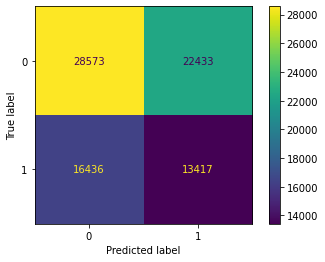

In [ ]:
metrics5, metrics_train5, y_pred5 = evaluate_classifier(gs5, X_test, y_test, y_train, y_pred_train5, pos_label=1,model_name='RandomForestClassifier, PCA')

# Save y_pred
filename = 'y_pred5' 
savepickle(y_pred5,filename,path=path, ext='.sav', append_version=True)

## Fit same model with balanced data

In [ ]:
# Load balanced data sets
path=r'drive/MyDrive/data exercises'
X_train_balanced = loadpickle('X_train_balanced2022-11-18_1849', path)
X_test_balanced = loadpickle('X_test_balanced2022-11-18_1850', path)


In [ ]:
y_train_balanced = loadpickle('y_train_balanced2022-11-18_2001', path)
y_test_balanced = loadpickle('y_test_balanced2022-11-18_2001', path)

In [ ]:

gs5b = gs5.fit(X_train_balanced, y_train_balanced)

filename = 'grid_search5_result.sav' 
savepickle(gs5b,filename,path=path, append_version=True)

y_pred_train5b = gs5b.predict(X_train_balanced)

File saved:  drive/MyDrive/data exercises/grid_search5_result.sav2022-11-18_2112sav


In [ ]:
gs5b.best_estimator_

Pipeline(steps=[('features',
                 Pipeline(steps=[('pca', 'passthrough'),
                                 ('selectkbest', SelectKBest(k=8))])),
                ('model',
                 ClfSwitcher(estimator=RandomForestClassifier(class_weight='balanced',
                                                              min_samples_leaf=5,
                                                              n_estimators=150,
                                                              random_state=0)))])

In [ ]:
# Updated 2022-11-18 10:45 so roc score prints even if classification dtypes are float.
# Updated so that y_pred_train is passed instead of X_train to avoid having to refit the model.
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
def evaluate_classifier(classifier, X_test, y_test, y_train, y_pred_train, pos_label=1,model_name='classifier', confusion=True,roc=True):
    """
    Print evaluation metrics of the classifier. Classifier should be fit prior to calling this function.
        * recall
        * precision
        * F1
        * AUC score (only if class labels are integers)
    Plot:
        * confusion matrix
        * ROC (only if class labels are integers)
    Parameters:
    - pos_label (str or int): Class label for positive class. Default is 1.
    - model_name (string, optional): Name of model printing purposes.
    - confusion_matrix (bool): If True (default), print the confusion matrix. 
    - roc (bool): If true, provide roc-auc score and plot.

    Returns 2 dictionaries:
    - evaluation metrics for test data
    - evaluation metrics train data set
    """
    
    best_model = classifier
    print(best_model.best_estimator_)

    y_pred = best_model.predict(X_test)

    # y_pred_train = best_model.predict(X_train)

    # Metrics for test data
    metrics = dict()
    if len(set(y_test)) == 2:
        recall = recall_score(y_test, y_pred, pos_label=pos_label)
        precision = precision_score(y_test, y_pred, pos_label=pos_label)
        f1score = f1_score(y_test, y_pred, pos_label=pos_label)
        metrics['recall'] = recall
        metrics['precision'] = precision
        metrics['f1'] = f1score

    accuracy = accuracy_score(y_test, y_pred)
    metrics['accuracy'] = accuracy

    # Metrics for training data
    metrics_train = dict()
    if len(set(y_test)) == 2:
        recall_train = recall_score(y_train, y_pred_train, pos_label=pos_label)
        precision_train = precision_score(y_train, y_pred_train, pos_label=pos_label)
        f1score_train = f1_score(y_train, y_pred_train, pos_label=pos_label)
        metrics_train['recall'] = recall_train
        metrics_train['precision'] = precision_train
        metrics_train['f1'] = f1score_train
    accuracy_train = accuracy_score(y_train, y_pred_train)
    metrics_train['accuracy'] = accuracy_train

    print(f'\n{model_name} evaluation metrics: \n\tTest data\tTraining data\t\tDifference')
    print(f'Accuracy: \t{100*accuracy:.2f}%\t\t{100*accuracy_train:.2f}%\t\t{100*(accuracy-accuracy_train):.2f}%')
    if len(set(y_test)) == 2:
        print(f'Recall: \t{100*recall:.2f}%\t\t{100*recall_train:.2f}%\t\t{100*(recall-recall_train):.2f}%')
        print(f'Precision: \t{100*precision:.2f}%\t\t{100*precision_train:.2f}%\t\t{100*(precision-precision_train):.2f}%')
        print(f'F1: \t\t{100*f1score:.2f}%\t\t{100*f1score_train:.2f}%\t\t{100*(f1score-f1score_train):.2f}%')
        if roc==True:
            auc = roc_auc_score(y_test, y_pred)
            auc_train = roc_auc_score(y_train, y_pred_train)
            RocCurveDisplay.from_predictions(y_test, y_pred)
            metrics['auc'] = auc
            print(f'AUC: \t\t{100*auc:.2f}%\t\t{100*auc_train:.2f}%\t\t{100*(auc-auc_train):.2f}%')
    if confusion==True:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred)

    return metrics, metrics_train, y_pred, matrix

Pipeline(steps=[('features',
                 Pipeline(steps=[('pca', 'passthrough'),
                                 ('selectkbest', SelectKBest(k=8))])),
                ('model',
                 ClfSwitcher(estimator=RandomForestClassifier(class_weight='balanced',
                                                              min_samples_leaf=5,
                                                              n_estimators=150,
                                                              random_state=0)))])

RandomForestClassifier with SelectKBest evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	72.61%		77.14%		-4.53%
Recall: 	82.61%		85.53%		-2.92%
Precision: 	62.93%		73.24%		-10.31%
F1: 		71.44%		78.91%		-7.47%
AUC: 		74.07%		77.14%		-3.07%


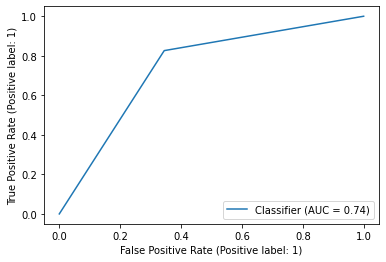

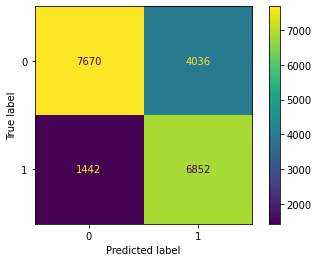

In [ ]:
metrics5b, metrics_train5b, y_pred5b, confusion5b = evaluate_classifier(gs5b, X_test_balanced, y_test_balanced, y_train_balanced, y_pred_train5b, 
                                    pos_label=1,model_name='RandomForestClassifier with SelectKBest',confusion=True,roc=True)